# Eccentricity Truncation Level Exploration
Using TidalPy's high-level functional programming, we will see how different eccentricity truncation levels affect tidal dissipation.

Also see the TidalPy/Papers/Renaud+2020 Notebook

In [1]:
import math
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors

from TidalPy import build_world
from TidalPy.tools.toolbox import dual_dissipation_from_dict_or_world_instance as calculate_dissipation
from TidalPy.tools.conversions import orbital_motion2semi_a
from TidalPy.utilities.numpy_helper.array_other import neg_array_for_log_plot, find_nearest
from TidalPy.utilities.graphics.cmaps import vik_map, tofino_map, lajolla_map, lajolla_map_r, cork_map
from TidalPy.constants import radius_earth, mass_earth, mass_solar, radius_solar, au 

# Setup plot style
_colors = np.vstack((lajolla_map_r(np.linspace(0., 1, 128)), lajolla_map(np.linspace(0., 1, 128))))
divergence_lajolla = mcolors.LinearSegmentedColormap.from_list('divergence_lajolla', _colors)
plt.rcParams.update({'font.size': 14})
saturation_percent = .8
vik_N = vik_map.N
# Colorblind safe reds and blues
red = vik_map(math.floor(vik_N * saturation_percent))
blue = vik_map(math.floor(vik_N * (1 - saturation_percent)))

# Build a simple homogenious planet around a star
host = build_world('sol')
planet = build_world('earth_simple')

In [2]:
# Rheological Parameters
rheologies = {
    'Andrade': ('b', 'andrade', (0.3, 1.0)),
    'Maxwell': ('k', 'maxwell', tuple()),
    'Sundberg': ('m', 'sundberg', (0.2, 0.02, 0.3, 1.0)),
    'Sundberg-Cooper': ('m', 'sundberg', (0.2, 0.02, 0.3, 1.0)),
    'CPL': ('g', 'cpl', tuple()),
    'CTL': ('c', 'ctl', tuple()),
    'Off': ('gray', 'Off', tuple())
}

## Setup calculation and plotting function

In [17]:
def truncation_level_plots(target_obliquity=0., target_viscosity=1.e22, target_shear=50.e9, target_rheo='Sundberg-Cooper',
                           target_k2=0.33, target_q=100.,
                           orbital_period: float = 10.,
                           host_spin_period: float = None, host_k2=0.33, host_q=6000., host_obliquity = 0.,
                           order_l_cases: Tuple[int, int, int, int] = (2, 2, 2, 2),
                           eccentricity_trunc_cases: Tuple[int, int, int, int] = (2, 6, 10, 20), 
                           zpoints=np.linspace(-4, 4, 60), zticks=(-4, -2, 0, 2, 4),
                           ztick_names = ('$-10^{4}$', '$-10^{2}$', '$0$', '$10^{2}$', '$10^{4}$'),
                           resolution: int = 350):
    
    # Pull out data
    constant_orbital_freq = 2. * np.pi / (orbital_period * 86400.)
    if host_spin_period is None:
        constant_host_spin_rate = constant_orbital_freq
    else:
        constant_host_spin_rate = 2. * np.pi / (host_spin_period * 86400.)
    constant_semi_major_axis = orbital_motion2semi_a(constant_orbital_freq, host.mass, planet.mass)
    rheo_color, rheo_name, rheo_input = rheologies[target_rheo]
    use_obliquity = (target_obliquity != 0.) or (host_obliquity != 0.)

    # Domains
    eccentricity_domain = np.logspace(-2, 0., int(resolution/2))
    spin_scale_domain = np.linspace(0., 3., int(resolution/2))
    #    Make sure to hit resonances
    spin_scale_domain_res = np.asarray([0.5, 1., 1.5, 2., 2.5, 3.])
    spin_scale_domain = \
        np.sort(np.concatenate((spin_scale_domain, spin_scale_domain_res)))
    spin_domain = spin_scale_domain * constant_orbital_freq
    eccentricity, spin_rate = np.meshgrid(eccentricity_domain, spin_domain)
    shape = eccentricity.shape
    eccentricity = eccentricity.flatten()
    spin_rate = spin_rate.flatten()

    # Make sure that all input arrays have the correct shape
    x = eccentricity_domain
    y = spin_scale_domain
    target_obliquity *= np.ones_like(eccentricity)
    host_obliquity *= np.ones_like(eccentricity)
    constant_orbital_freq *= np.ones_like(spin_rate)
    constant_semi_major_axis *= np.ones_like(spin_rate)
    constant_host_spin_rate *= np.ones_like(constant_orbital_freq)
    #   Find spin_sync index
    sync_index = find_nearest(spin_scale_domain, 1.)

    # Cases that are plotted (must be equal to 4, must have the format (order-l, eccentricity_trunc)
    if len(order_l_cases) != 4 or len(eccentricity_trunc_cases) != 4:
        raise ValueError('Both order_l_cases and eccentricity_trunc_cases must each have 4 cases.')
        
    case_line_styles = ['-', '--', '-.', ':']
    case_names = ['$\\mathcal{O}(e^{' + f'{trunc_level}' + '}$)' if order_l == 2 
                  else '$l = ' + f'{order_l}' + ', \\mathcal{O}(e^{' + f'{trunc_level}' + '}$)'
                  for order_l, trunc_level in zip(order_l_cases, eccentricity_trunc_cases)]

    # Setup plots
    #    Contour Figure
    fig_contours = plt.figure(figsize=(6.75*1.75, 4.8), constrained_layout=True)
    ratios = (.249, .249, .249, .249, .02)
    gs_contours = GridSpec(1, 5, figure=fig_contours, width_ratios=ratios)
    case_contour_axes = [fig_contours.add_subplot(gs_contours[0, i]) for i in range(4)]
    colorbar_ax = fig_contours.add_subplot(gs_contours[0, 4])

    #    Spin-sync Figure
    fig_sync, sync_axes = plt.subplots(ncols=2, figsize=(1.5 * 6.4, 4.8))
    fig_sync.subplots_adjust(wspace=0.4)
    fig_sync.suptitle('Spin Synchronous', fontsize=16)
    sync_heating_ax = sync_axes[0]
    sync_eccen_ax = sync_axes[1]

    # Labels
    for ax in [sync_heating_ax, sync_eccen_ax] + case_contour_axes:
        if ax in [sync_heating_ax, sync_eccen_ax]:
            ax.set(xlabel='Eccentricity', xscale='linear')
        else:
            ax.set(xlabel='Eccentricity', xscale='log')
        
    for ax in fig_contours.get_axes():
        ax.label_outer()

    case_contour_axes[0].set(ylabel='$\\dot{\\theta} \\; / \\; n$')
    sync_heating_ax.set(ylabel='Tidal Heating [W]', yscale='log')
    sync_eccen_ax.set(ylabel='$\\dot{e}$ [yr$^{-1}$]', yscale='log')

    for case_i, (order_l, eccentricity_trunc) in enumerate(zip(order_l_cases, eccentricity_trunc_cases)):
        
        # Calculate Derivatives
        dissipation_results = \
            calculate_dissipation(
                host, planet,
                viscosities=(None, target_viscosity), shear_moduli=(None, target_shear),
                rheologies=('fixed_q', rheo_name), complex_compliance_inputs=(None, rheo_input),
                obliquities=(host_obliquity, target_obliquity),
                spin_frequencies=(constant_host_spin_rate, spin_rate),
                tidal_scales=(1., 1.),
                fixed_k2s=(host_k2, target_k2), fixed_qs=(host_q, target_q),
                eccentricity=eccentricity, orbital_frequency=constant_orbital_freq,
                max_tidal_order_l=order_l, eccentricity_truncation_lvl=eccentricity_trunc,
                use_obliquity=use_obliquity,
        # The following scales convert da/dt & de/dt to yr-1; d^2theta/dt^2 to yr^-2
                da_dt_scale=(3.154e7 / 1000.), de_dt_scale=3.154e7,
                dspin_dt_scale=((360. / (2. * np.pi)) * 3.154e7**2))
        
        tidal_heating_targ = dissipation_results['secondary']['tidal_heating']
        dspin_dt_targ = dissipation_results['secondary']['spin_rate_derivative']
        de_dt = dissipation_results['eccentricity_derivative']
        da_dt = dissipation_results['semi_major_axis_derivative']
        
        # Reshape
        tidal_heating_targ = tidal_heating_targ.reshape(shape)
        dspin_dt_targ = dspin_dt_targ.reshape(shape)
        de_dt = de_dt.reshape(shape)
        
        # Prep for log plotting
        dspin_dt_targ_pos, dspin_dt_targ_neg = neg_array_for_log_plot(dspin_dt_targ)
        de_dt_pos, de_dt_neg = neg_array_for_log_plot(de_dt)

        # Make data Symmetric Log (for negative logscale plotting)
        logpos = np.log10(np.copy(dspin_dt_targ_pos))
        logpos[logpos < 0.] = 0.
        negative_index = ~np.isnan(dspin_dt_targ_neg)
        logneg = np.log10(dspin_dt_targ_neg[negative_index])
        logneg[logneg < 0.] = 0.
        dspin_dt_targ_combo = logpos
        dspin_dt_targ_combo[negative_index] = -logneg

        # Plot Contours
        case_name = case_names[case_i]
        contour_ax = case_contour_axes[case_i]
        contour_ax.set(title=case_name)
        cb_data = contour_ax.contourf(x, y, dspin_dt_targ_combo, zpoints, cmap=vik_map)
    
        for c in cb_data.collections:
            c.set_edgecolor("face")
        
        # Plot Spin Sync
        case_style = case_line_styles[case_i]
        #    Find sync data
        tidal_heating_sync = tidal_heating_targ[sync_index, :]
        de_dt_neg_sync = de_dt_neg[sync_index, :]
        de_dt_pos_sync = de_dt_pos[sync_index, :]
        #    Plot
        sync_heating_ax.plot(x, tidal_heating_sync, c=red, ls=case_style, label=case_name)
        sync_eccen_ax.plot(x, de_dt_neg_sync, c=blue, ls=case_style, label=case_name)
        sync_eccen_ax.plot(x, de_dt_pos_sync, c=red, ls=case_style)
        
        print(f'Case {case_i+1} completed.', end='\r')

    # Add color bar
    cb = plt.colorbar(cb_data, pad=0.03, cax=colorbar_ax, ticks=zticks)
    spaces = '$' + '\\; '*14 + '$'
    cb.set_label('Decelerating ' + spaces + 'Accelerating\n$\\ddot{\\theta}$ [deg yr$^{-2}$]')
    cb.ax.set_yticklabels(ztick_names)
    
    # Add Spin-Sync Legend
    custom_lines = [Line2D([0], [0], color='k', lw=2, ls=style) for style in case_line_styles]
    sync_heating_ax.legend(custom_lines, case_names, loc='upper left')
    
    # Add Grid lines
    sync_heating_ax.grid(axis='x', which='major', alpha=0.5, ls='--')
    sync_heating_ax.grid(axis='x', which='minor', alpha=0.45, ls='-.')
    sync_eccen_ax.grid(axis='x', which='major', alpha=0.5, ls='--')
    sync_eccen_ax.grid(axis='x', which='minor', alpha=0.45, ls='-.')

    plt.show()

## Plot some results
Change around the various inputs and see what happens!

Function time will be slow the first time you make a call to a new combination of `order_l` and `eccentricity_trunc` as background functions compile.

### No Obliquity

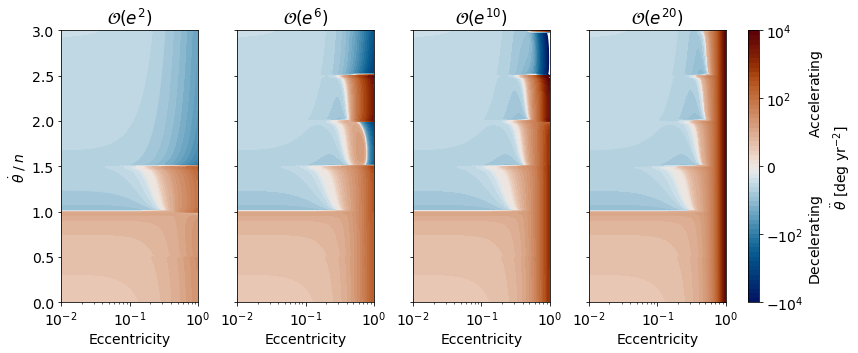

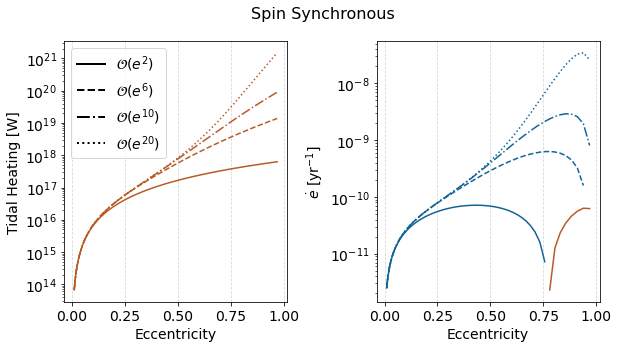

In [16]:
truncation_level_plots(target_obliquity=0., target_viscosity=1.e22, target_shear=50.e9, target_rheo='Sundberg-Cooper',
                       target_k2=0.33, target_q=100., 
                       orbital_period=6.,
                       host_spin_period=None, host_k2=0.33, host_q=6000., host_obliquity=0.,
                       order_l_cases=(2, 2, 2, 2),
                       eccentricity_trunc_cases=(2, 6, 10, 20), 
                       zpoints=np.linspace(-4, 4, 60), zticks=(-4, -2, 0, 2, 4),
                       ztick_names=('$-10^{4}$', '$-10^{2}$', '$0$', '$10^{2}$', '$10^{4}$'))

### Non-Zero Obliquity

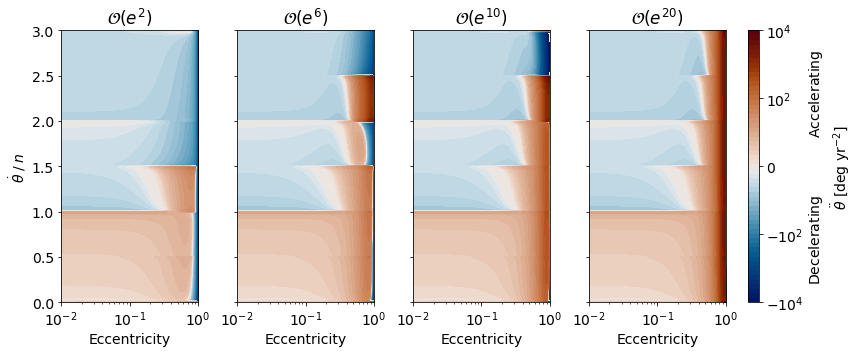

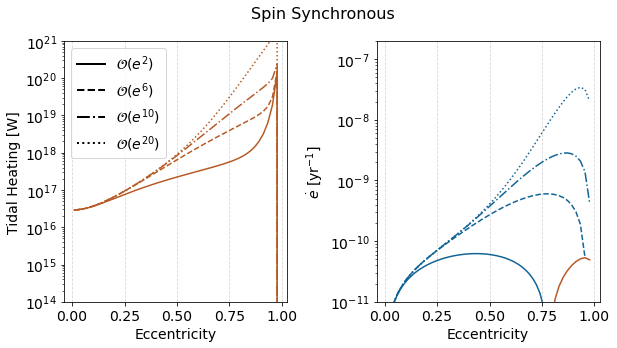

In [5]:
truncation_level_plots(target_obliquity=np.radians(35.), target_viscosity=1.e22, target_shear=50.e9,
                       target_rheo='Sundberg-Cooper',
                       target_k2=0.33, target_q=100., 
                       orbital_period=6.,
                       host_spin_period=None, host_k2=0.33, host_q=6000., host_obliquity=0.,
                       order_l_cases=(2, 2, 2, 2),
                       eccentricity_trunc_cases=(2, 6, 10, 20), 
                       zpoints=np.linspace(-4, 4, 60), zticks=(-4, -2, 0, 2, 4),
                       ztick_names=('$-10^{4}$', '$-10^{2}$', '$0$', '$10^{2}$', '$10^{4}$'))

### Highly Dissipative, NSR Host

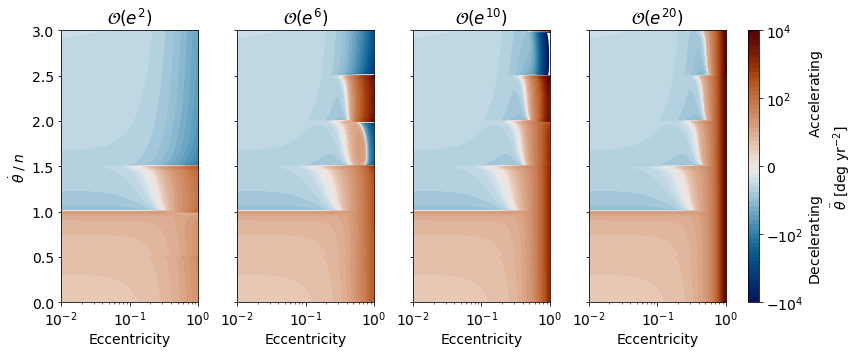

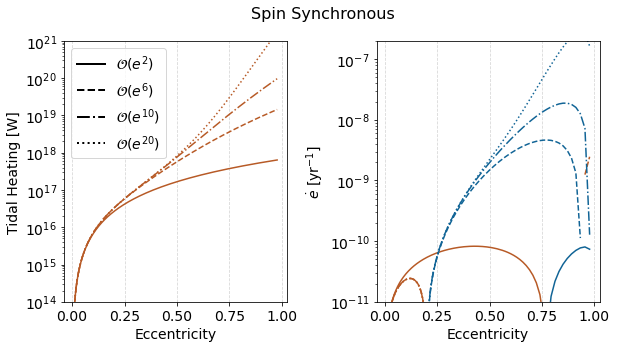

In [6]:
truncation_level_plots(target_obliquity=0., target_viscosity=1.e22, target_shear=50.e9,
                       target_rheo='Sundberg-Cooper',
                       target_k2=0.33, target_q=100., 
                       orbital_period=6.,
                       host_spin_period=3., host_k2=0.33, host_q=10., host_obliquity=0.,
                       order_l_cases=(2, 2, 2, 2),
                       eccentricity_trunc_cases=(2, 6, 10, 20), 
                       zpoints=np.linspace(-4, 4, 60), zticks=(-4, -2, 0, 2, 4),
                       ztick_names=('$-10^{4}$', '$-10^{2}$', '$0$', '$10^{2}$', '$10^{4}$'))

### Different Viscoelastic Properties

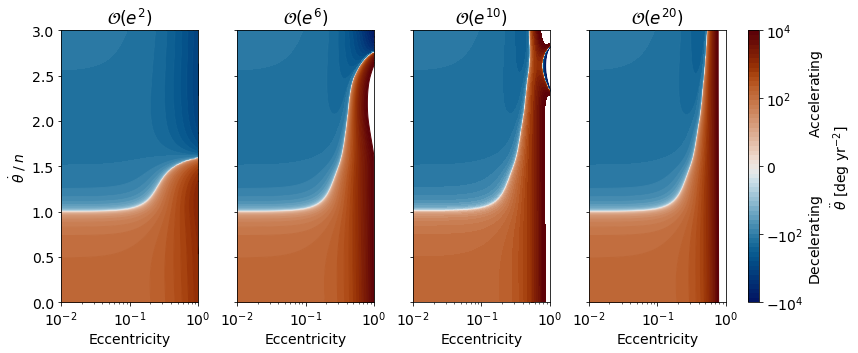

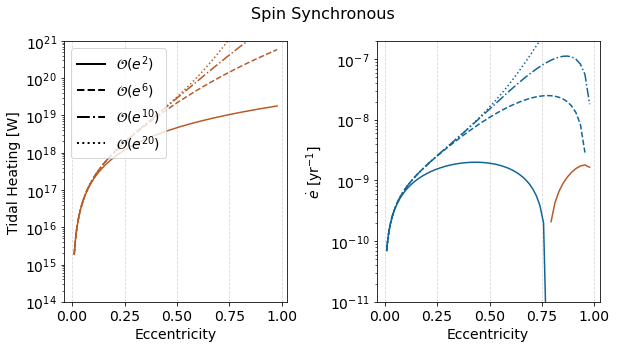

In [7]:
truncation_level_plots(target_obliquity=0., target_viscosity=1.e14, target_shear=3.e9, target_rheo='Sundberg-Cooper',
                       target_k2=0.33, target_q=100., 
                       orbital_period=6.,
                       host_spin_period=None, host_k2=0.33, host_q=6000., host_obliquity=0.,
                       order_l_cases=(2, 2, 2, 2),
                       eccentricity_trunc_cases=(2, 6, 10, 20), 
                       zpoints=np.linspace(-4, 4, 60), zticks=(-4, -2, 0, 2, 4),
                       ztick_names=('$-10^{4}$', '$-10^{2}$', '$0$', '$10^{2}$', '$10^{4}$'))

### Higher Order-l
These can take quite a while to run!

We move the planet much closer to allow for more difference at the higher l's.

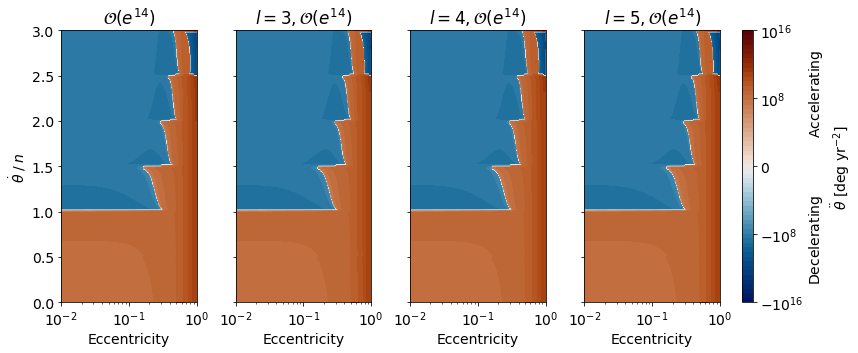

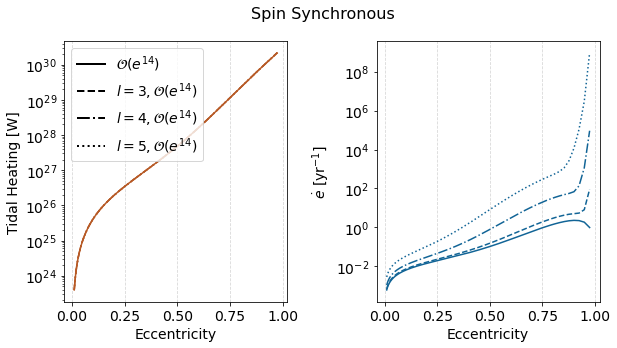

In [24]:
truncation_level_plots(target_obliquity=0., target_viscosity=1.e22, target_shear=50.e9, target_rheo='Sundberg-Cooper',
                       target_k2=0.33, target_q=100., 
                       orbital_period=0.05,
                       host_spin_period=None, host_k2=0.33, host_q=6000., host_obliquity=0.,
                       order_l_cases=(2, 3, 4, 5),
                       eccentricity_trunc_cases=(14, 14, 14, 14), 
                       zpoints=np.linspace(-16, 16, 60), zticks=(-16, -8, 0, 8, 16),
                       ztick_names=('$-10^{16}$', '$-10^{8}$', '$0$', '$10^{8}$', '$10^{16}$'))